In [1]:
from IPython.display import display
from IPython.display import Image
from IPython.display import HTML
from utils import * # Code shared across more than one notebook

# gVirtualXRay image vs Plastimatch DRR
**Outline:** the aim of this experiment is to assess the validity of applications that use gVirtualXRay to simulate radiographs. We propose that comparing a gVirtualXRay image of the [Lungman chest phantom](https://www.kyotokagaku.com/en/products_data/ph-1_01/) to a [Plastimatch](https://plastimatch.org/) DRR of the same sample is a sufficient way to test the accuracy of simulated radiographs. 


1. The CT of a chest phantom has been generated from a real scanner ahead of time. 
2. Surfaces have been extracted from notebook-11. 
4. Simulate radiographs on the model with gVirtualXRay at specific orientations.
5. Generate DRRs from the lungman CT at the same patient orientations using [Plastimatch drr](https://plastimatch.org/drr.html). 
6. Compare the simulated radiographs to the ground truth DRRs.

**Methods and materials:** This notebook continues from notebook 11-gVirtualXRay_vs_lungman.ipynb and we reuse the same lungman model. As a result, most parameters are equal to the previous experiment. To achieve a parallel projection when generating a DRR, SAD and SID parameters have been set effectively to infinity.

Plastimatch parameter "centre" has been optimised using [pymoo's](https://pymoo.org/) implentation of the [multi-objective algorithm](https://en.wikipedia.org/wiki/Multi-objective_optimization) NSGA-II.


We present two orientations in this notebook: a left to right projection; a maximum number of samples approach to test the model and a chest study projection (Anterior to posterior) which demonstrates a realistic use for gVirtualXRay. 

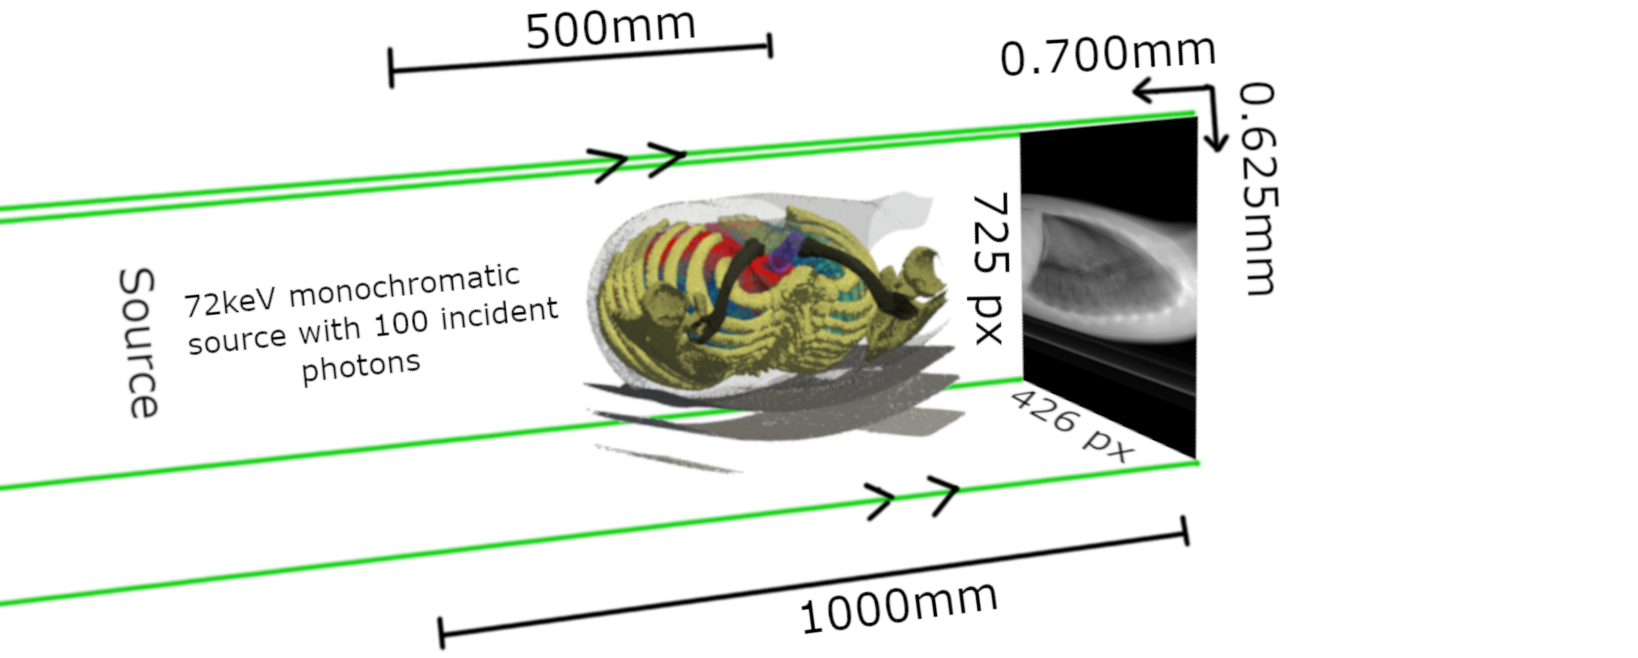

In [2]:
Image("../doc/gvxr-lungman-environment.png", width=800)

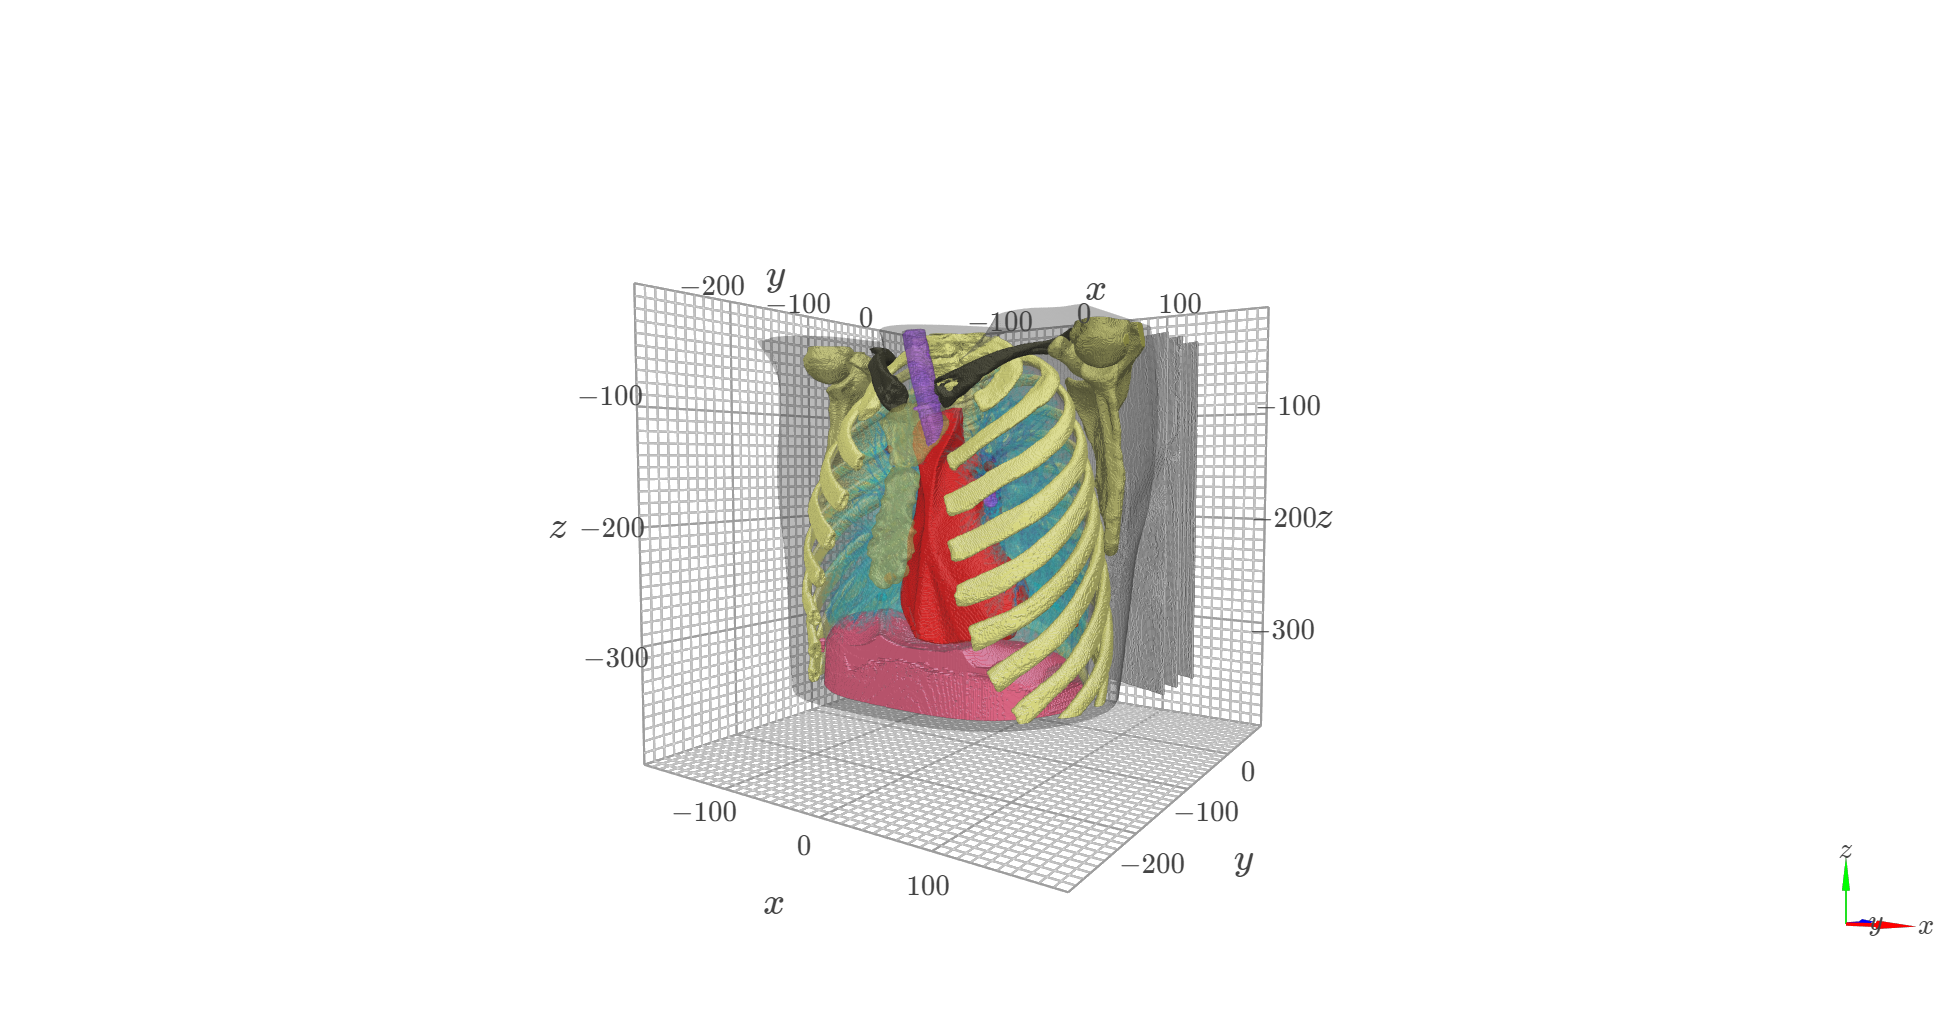

In [3]:
Image("./lungman_data/k3d_lungman_visualisation.png", width=800)

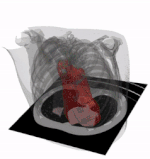

In [4]:
with open('../doc/chest-paraview.gif','rb') as f:
       display(Image(data=f.read(), format='png', width=240))

# Results
**Diagonal plot comparison:** The plots show samples taken from the diagonal of both the A-P DRR and A-P gVirtualXRay radiograph.

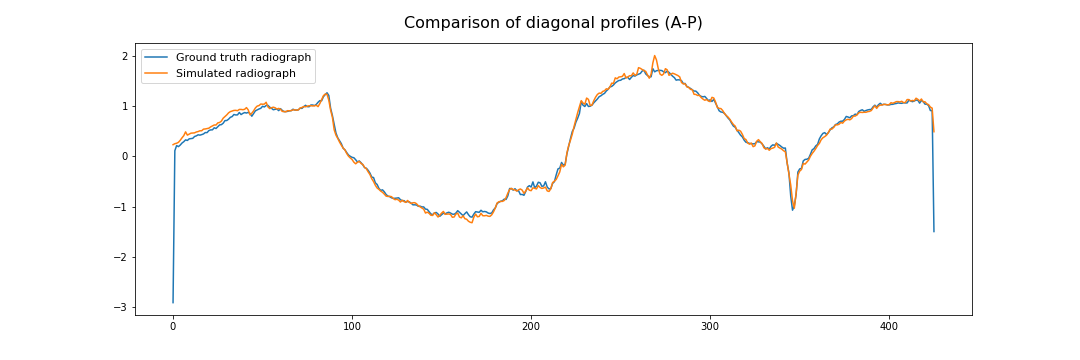

In [5]:
Image('plots/lungman-radiograph-profiles.png')

**Quantitative comparisons**\
From qauntative measures we achieved: a [ZNCC](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)) score of 99.75%, a [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) 0.32, a [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) 0.03, a [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)  0.07, and a [SSIM](https://en.wikipedia.org/wiki/Structural_similarity)  score of 0.93. For reference, a strong ZNCC and SSIM score is 1 and a good MAPE score is 0.


In [6]:
import pandas as pd
df = pd.DataFrame([["99.75%",0.029, 0.070, 0.317, 0.932],["98.71%",0.059,  0.161, 0.409, 0.867]],
                  index=['R-L','A-P'],
                  columns=['ZNCC', 'MAE','RMSE', 'MAPE','SSIM'])
pd.set_option("display.precision", 2)

display(df)

,ZNCC,MAE,RMSE,MAPE,SSIM
R-L,99.75%,0.03,0.07,0.32,0.93
A-P,98.71%,0.06,0.16,0.41,0.87


## The calculations were performed on the following platform:

In [7]:
printSystemInfo();

OS:
	Windows 10
	AMD64

CPU:
 	AMD Ryzen 5 5600X 6-Core Processor

RAM:
	16 GB
GPU:
	Name: NVIDIA GeForce GTX 970
	Drivers: 496.49
	Video memory: 4 GB


# Import packages

In [8]:
import os
import SimpleITK as sitk
import numpy as np
from convertRaw import *
import gvxrPython3 as gvxr
import json2gvxr
import matplotlib.pyplot as plt
from tifffile import imread, imsave # Load/Write TIFF files
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_percentage_error
import datetime
import k3d

SimpleGVXR 1.0.1 (2021-12-06T23:05:25) [Compiler: Microsoft Visual Studio] on Windows
gVirtualXRay core library (gvxr) 1.1.5 (2021-12-06T23:05:24) [Compiler: Microsoft Visual Studio] on Windows


# Configure gVirtualXRay environment

**Create an OpenGL context and window.**

In [9]:
json2gvxr.initGVXR("notebook-11.json", "OPENGL");

Create an OpenGL context: 512x512


**Create a photon beam.**

In [10]:
json2gvxr.initSourceGeometry();

Set up the beam
	Source position: [0, -500, 0, 'mm']
	Source shape: ParallelBeam


**Create a detector array.**

In [11]:
json2gvxr.initDetector("notebook-11.json");

Set up the detector
	Detector position: [0, 500, 0, 'mm']
	Detector up vector: [0, 0, -1]
	Detector number of pixels: [512, 426]
	Pixel spacing: [0.625, 0.7, 'mm']


In [12]:
gvxr.setMonoChromatic(100, "keV", 1);

**Create a phantom model from each mesh and its material.**

In [13]:
json2gvxr.initSamples("notebook-11.json", 1);

Load the 3D data

	Load 100HU_tumours in lungman_data/meshes/tumours_100HU.stl using mm
	Load -630HU_tumours in lungman_data/meshes/tumours_630HU.stl using mm
	Load Clavicle in lungman_data/meshes/clavicle.stl using mm
	Load Heart in lungman_data/meshes/heart.stl using mm
	Load Bronchus in lungman_data/meshes/bronchus.stl using mm
	Load Diaphram in lungman_data/meshes/diaphram.stl using mm
	Load Bronchioles in lungman_data/meshes/bronchioles.stl using mm
	Load Ribs_Spine in lungman_data/meshes/ribs_spine.stl using mm
	Load Scapulas in lungman_data/meshes/scapulas.stl using mm
	Load Sheets_high in lungman_data/meshes/sheets_high.stl using mm
	Load Sheets_low in lungman_data/meshes/sheets_low.stl using mm
	Load Sheets_med in lungman_data/meshes/sheets_med.stl using mm
	Load Skin in lungman_data/meshes/skin.stl using mm
	Load Sternum in lungman_data/meshes/sternum.stl using mm
	Load Trachea in lungman_data/meshes/trachea.stl using mm


**K3D visualisation of labelled model**

In [14]:
if (os.path.exists("./lungman_data/k3d_lungman_visualisation.png") == False):
    from stl import mesh
    from base64 import b64decode
    plot = k3d.plot()
    plot.background_color = 0xffffff

    for sample in json2gvxr.params["Samples"]:

        label = sample["Label"]

        fname = sample["Path"]

        R = sample["Colour"][0];
        G = sample["Colour"][1];
        B = sample["Colour"][2];
        o = sample["Colour"][3];

        k3d_color = 0;
        k3d_color |= (R & 255) << 16;
        k3d_color |= (G & 255) << 8;
        k3d_color |= (B & 255);

        mesh_from_stl_file = mesh.Mesh.from_file(fname)

        opacity = o;
        #if (label == "Bronchioles"): opacity = 0.05;
        geometry = k3d.mesh(mesh_from_stl_file.vectors.flatten(),
                                  range(int(mesh_from_stl_file.vectors.flatten().shape[0] / 3)),
                                  color=k3d_color, 
                                  wireframe=False, 
                                  flat_shading=False,
                                  name=fname,
                                  opacity=opacity)

        plot += geometry   

    plot.display()
    
    plot.fetch_screenshot()
    f = open("./lungman_data/k3d_lungman_visualisation.png", 'wb');
    screenshot = b64decode(plot.screenshot);
    f.write(screenshot)
    f.flush();
    f.close();

**Get the number of triangles**

In [15]:
number_of_triangles = 0

for sample in json2gvxr.params["Samples"]:
    label = sample["Label"]
    number_of_triangles_in_mesh = gvxr.getNumberOfPrimitives(label)
    number_of_triangles += number_of_triangles_in_mesh
    
print("There are", f"{number_of_triangles:,}", "triangles in total")

There are 19,277,756 triangles in total


# Capture gVirtualXRay projections

**Rotate to achieve the desired orientation and create a gVirtualXRay projection of the scene.**

In [16]:
gvxr.rotateScene(90, 0, 0, 1);
runtimes = [];

time_start = datetime.datetime.now();
gxvr_image = gvxr.computeXRayImage()
time_diff_ms = (datetime.datetime.now() - time_start).total_seconds() * 1000;
runtimes.append(time_diff_ms);
xray_RL = np.array(gxvr_image);


**Rotate again to get a A-P or medical projection.**

In [17]:

gvxr.rotateScene(90, 0, 0, 1);

time_start = datetime.datetime.now();
gxvr_image = gvxr.computeXRayImage()
time_diff_ms = (datetime.datetime.now() - time_start).total_seconds() * 1000;
runtimes.append(time_diff_ms);
xray_AP = np.array(gxvr_image);

gvxr_image = None;

In [18]:
runtimes_std = round(np.std(runtimes));
runtimes_mean = round(np.mean(runtimes));

**Flat field the detector's image.**\
Taking advantage of the detector response when there is no sample can help improve the quality of images when a sample is present. To elaborate, any variance between pixels when the detector is dark (X-Ray beam off) or full (X-Ray beam on) with no density will affect the quality of images with a sample. Factoring for this systematic error is called flat-field correction. \
N: corrected image\
P: projection\
D: dark field\
F: full field\
$N = \frac{P - D}{F - D}$\
In this routine the projection data is flat-fielded.

In [19]:
def correctFlatFieldToFile(projections, fname):
    if not os.path.exists(fname):
        projections = flatFieldCorrection(projections)
        
        sitk_image = sitk.GetImageFromArray(projections)
        # sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
        sitk.WriteImage(sitk_image, fname, useCompression=True)
    else:
        temp = sitk.ReadImage(fname)
        projections = sitk.GetArrayFromImage(temp)
        projections = projections.astype(np.single);
        
    return projections;

xray_RL = correctFlatFieldToFile(xray_RL, "gVirtualXRay_output_data/lungman_corrected_R_L_proj.mha");
xray_AP = correctFlatFieldToFile(xray_AP, "gVirtualXRay_output_data/lungman_corrected_A_P_proj.mha");

**Normalise the image with a minus log transform.**

Ensure log is greater than or equal t zero.

Perform negative log.

Adjust for pixel spacing.

In [20]:
def minusLogToFile(projections, fname):

    if not os.path.exists(fname):
        projections = minusLog(projections)
        
        sitk_image = sitk.GetImageFromArray(projections)
        # sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
        sitk.WriteImage(sitk_image, fname, useCompression=True)
    else:
        temp = sitk.ReadImage(fname)
        projections = sitk.GetArrayFromImage(temp)
        projections = projections.astype(np.single);
    return projections;

xray_RL = minusLogToFile(xray_RL, "gVirtualXRay_output_data/lungman_minus_log_R_L_proj.mha");
xray_AP = minusLogToFile(xray_AP, "gVirtualXRay_output_data/lungman_minus_log_A_P_proj.mha");

**Display gVirtualXRay radiographs from both right to left and anterior to posterior orientations**

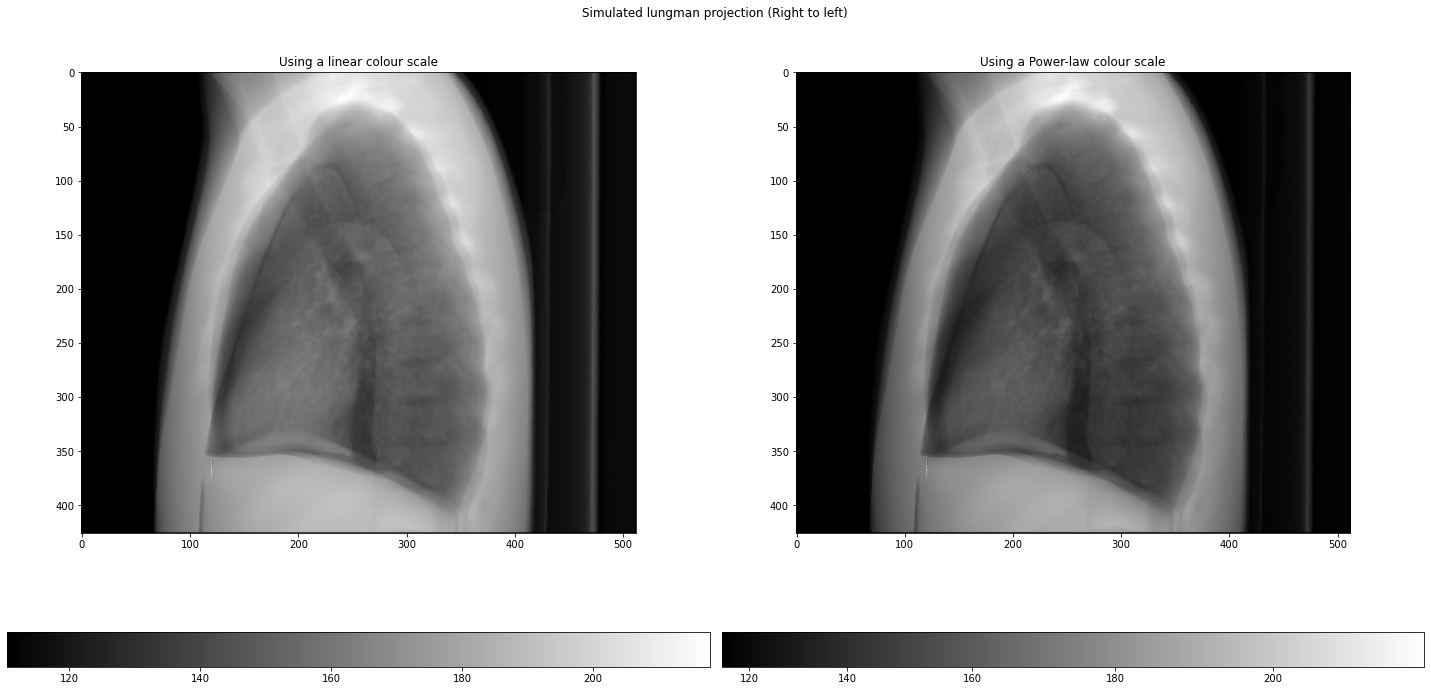

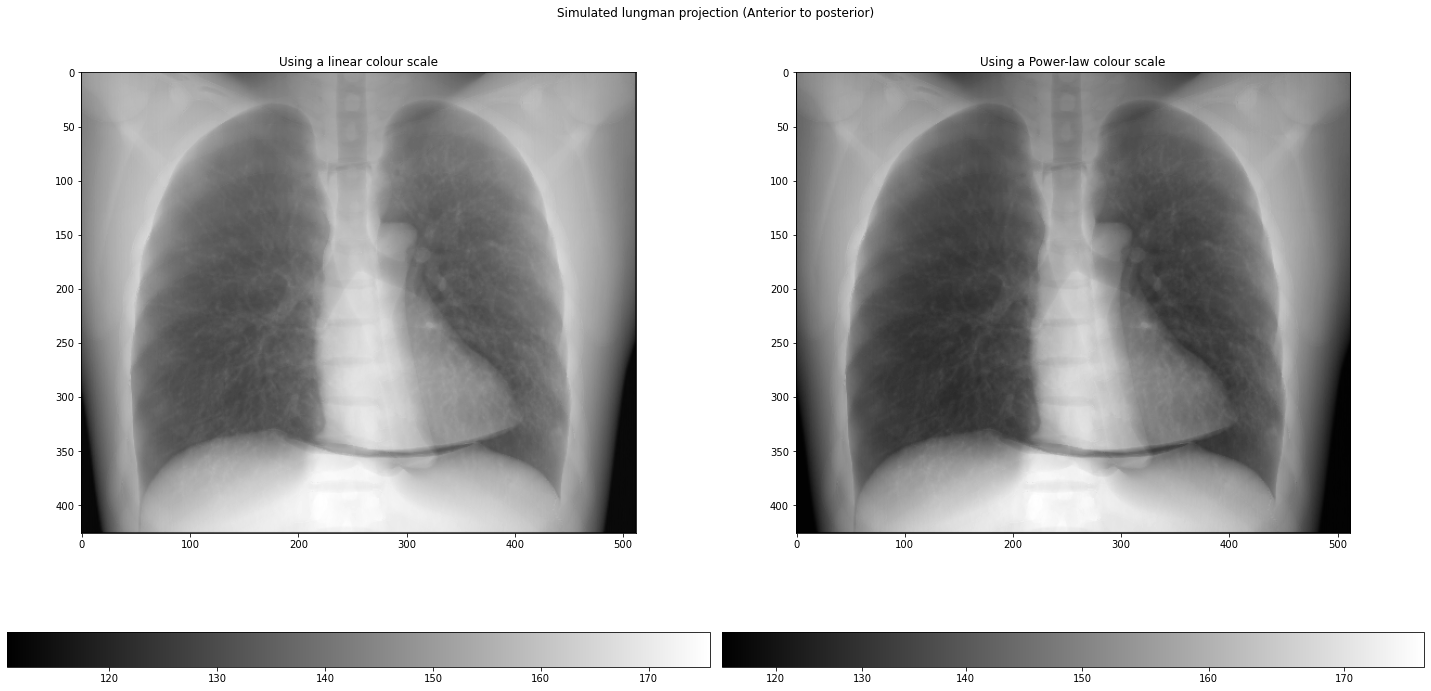

In [21]:
displayLinearPowerScales(xray_RL,  "Simulated lungman projection (Right to left)", "plots/R_L_lungman_radiograph");
displayLinearPowerScales(xray_AP,  "Simulated lungman projection (Anterior to posterior)", "plots/A_P_lungman_radiograph");

## Plastimatch Parameters
- Normal vector set to 1x,0y,0z or left to right (--nrm)
- Dectector up vector set to 0x,0x,1z (--vup)
- Reconstructed image dimensions 725 by 426 to match gvxr projection (-r)
- Detector size adjusted for spacing $725\times0.625$ by $426\times0.7$ (-z)
- Output type raw (-t)
- Source to detector and source to object set effectively to infinity, mimicking a parellel detector (--sid and --sad)

**This procedure reads the raw file generated by plastimatch**

In [22]:

#os.system('plastimatch drr --nrm "1 0 0" --vup "0 0 1" -r "725 426" -c "577 -57" -z "453.125 298.5" -t raw --sid 65535 --sad 65535 --output Plastimatch_data/DRR_RL lungman_data/lungman.mha');
#os.system('plastimatch drr --nrm "0 -1 0" --vup "0 0 1" -r "725 426" -c "349 -57" -z "453.125 298.5" -t raw --sid 65535 --sad 65535 --output Plastimatch_data/DRR_AP lungman_data/lungman.mha');

def readPlastimatchImageAsNumpy(path, width, height):
    image_DRR = read_raw(binary_file_name=path,
                 image_size=[width, height],
                 sitk_pixel_type=sitk.sitkFloat32,
                 big_endian="false",
                 verbose=False);
    if (os.path.exists(path) == False):
        print(binary_file_name + " does not exist");
    return np.array(sitk.GetArrayFromImage(image_DRR));


**Procedure to execute plastimatch drr program**

In [23]:
#def doDRR(out_arr_AP : np.array, out_arr_RL, iRLCX, iRLCY, iAPCX, iAPCY, in_lungman_full_path = "lungman_data/lungman.mha" ):
def doLungmanDRRNumpy(iNRMX, iNRMY, iNRMZ,
                      iCX , iCY , in_drr_out_name, 
                      iOutW = 512, iOutH = 426, 
                      iSID = 65535, iSAD = 65535,
                      iSpacingX = 0.625, iSpacingY = 0.7,
                      in_lungman_path = "lungman_data/lungman.mha" ):
    format = 'plastimatch drr --nrm "{iNRMX} {iNRMY} {iNRMZ}" --vup "0 0 1" -r "{iWidth} {iHeight}" -c "{iCX} {iCY}" -z "{iZx} {iZy}" -t raw --sid {sid} --sad {sad} --output Plastimatch_data/{out} {src}';
    iWAdjusted = iOutW * iSpacingX;
    iHAdjusted = iOutH * iSpacingY;
    sParam = format.format(sid=iSID,sad=iSAD,iNRMX=iNRMX, iNRMY=iNRMY,iNRMZ = iNRMZ, iCX = iCX, iCY = iCY, iZx = iWAdjusted, iZy = iHAdjusted, iWidth=iOutW, iHeight=iOutH, src=in_lungman_path, out = in_drr_out_name)
    #print(sParam)
    os.system(sParam);
    format = "Plastimatch_data/{in_name}0000.raw";
    drr= readPlastimatchImageAsNumpy(format.format(in_name = in_drr_out_name), iOutW, iOutH);
    return drr;

In [24]:
def normImage(image_to_normalise):
    image_to_normalise -= np.mean(image_to_normalise);
    stddev = np.std(image_to_normalise);
    if (stddev == 0): stddev = 0.0001;
    image_to_normalise/= stddev;
  

**Measure difference procedure, we include MAE, ZNCC, RMSE, MAPE and SSIM metrics**

In [25]:
def measure(truth, predict):
    N = 1.0;
    dims = np.shape(truth);
    for i in range(0, len(dims)):
        N *= dims[i];
    if (N == 0): return -1, -1, -1, -1, -1;
    
    zncc_denom = N * np.std(truth) * np.std(predict);
    if (zncc_denom == 0): zncc_denom = 0.00001;
        
    sub = truth - predict;
    
    mae_score = np.sum(np.abs(sub)) / N;
    zncc_score =  np.sum( (truth  - np.mean(truth)) *(predict - np.mean(predict))) / zncc_denom;
    rmse_score =  np.sqrt(np.sum(np.power(sub, 2)) / N)
    mape_score = mean_absolute_percentage_error(truth, predict);
    ssim_score = ssim(truth, predict);
    return mae_score, zncc_score, rmse_score, mape_score, ssim_score

# Optimise Plastimatch centre
**Use measure in objective function to find optimimum centre. i.e. register the DRR onto the radiograph**

In [26]:
from pymoo.util.misc import stack
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from threading import Thread

def objective(cx, cy):
        DRR = doLungmanDRRNumpy(g_NRM[0], g_NRM[1], g_NRM[2], 
                           cx, cy, 
                            "DRR_", 
                            g_XRay.shape[1], g_XRay.shape[0]
                            
                           );
        DRR = DRR.astype(np.single);
        normImage(DRR);
        mae, zncc, rmse, mape, ssim = measure(g_XRay, DRR);
        zncc = 1.0 - ((zncc + 1.0) /2.0);
        ssim = 1.0 - ssim;
        row = []
    
        row.append(mae);
        row.append(zncc);
        row.append(rmse);
        row.append(mape);
        row.append(ssim);
        return row;

class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=5,
                         n_constr=0,
                         xl=np.array([0, -g_XRay.shape[0]]),
                         xu=np.array([g_XRay.shape[1],0])
                         )
    
  
      
    
    def _evaluate(self, X, out, *args, **kwargs):
            objs = []
            for tuple in X:
                objs.append(objective(tuple[0], tuple[1]));

            out["F"] = objs;
        

In [27]:
import time
from pymoo.factory import get_termination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation

termination = get_termination("n_gen", 100)


algorithm = NSGA2(
    pop_size=20,
    n_offsprings=5,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=False
)
#normImage(xray_AP);
#normImage(xray_RL);

from pymoo.optimize import minimize

**Generate optimise result if not done so already**


In [28]:
import pymoo.core.result;
#470 -57
#240 -57

r_l_res_exists = os.path.exists("gVirtualXRay_output_data/R-L-res-nsga2-X.dat") and \
                 os.path.exists("gVirtualXRay_output_data/R-L-res-nsga2-F.dat");
    
a_p_res_exists = os.path.exists("gVirtualXRay_output_data/A-P-res-nsga2-X.dat") and \
                 os.path.exists("gVirtualXRay_output_data/A-P-res-nsga2-F.dat");

res_ap = pymoo.core.result.Result();
res_rl = pymoo.core.result.Result();

s="Time taken {t} seconds.";

if (r_l_res_exists):
    print("Getting R-L result from file");
    res_rl.X = np.loadtxt("gVirtualXRay_output_data/R-L-res-nsga2-X.dat")
    res_rl.F = np.loadtxt("gVirtualXRay_output_data/R-L-res-nsga2-F.dat")
else:
    print("Optimising R-L");
    g_NRM = [1, 0, 0]
    g_XRay = xray_RL;

    problem = MyProblem();

    t_start = time.time();
    res_rl = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

    t_end = time.time();
    print(s.format(t=(t_end - t_start)));
    
    np.savetxt("gVirtualXRay_output_data/R-L-res-nsga2-X.dat", res_rl.X)
    np.savetxt("gVirtualXRay_output_data/R-L-res-nsga2-F.dat", res_rl.F)

if (a_p_res_exists):
    print("Getting A-P result from file");
    res_ap.X = np.loadtxt("gVirtualXRay_output_data/A-P-res-nsga2-X.dat")
    res_ap.F = np.loadtxt("gVirtualXRay_output_data/A-P-res-nsga2-F.dat")
else:
    print("Optimising A-P");
    g_NRM = [0, -1, 0]
    g_XRay = xray_AP;
    
    problem = MyProblem();

    t_start = time.time();
    res_ap = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

    t_end = time.time();
    print(s.format(t=(t_end - t_start)));
    
    np.savetxt("gVirtualXRay_output_data/A-P-res-nsga2-X.dat", res_ap.X)
    np.savetxt("gVirtualXRay_output_data/A-P-res-nsga2-F.dat", res_ap.F)
    

Getting R-L result from file
Getting A-P result from file


# Visual comparisons
**Generate registered DRR and compare against radiograph of the same orientation**

In [29]:
DRR_RL = doLungmanDRRNumpy(1, 0, 0, 
                              res_rl.X[0][0], res_rl.X[0][1], 
                                "DRR_RL" 
                               );
normImage(xray_RL);
normImage(DRR_RL);
#quickCompare(DRR_RL, "DRR L-R", xray_RL, "X-Ray L-R", True);

In [30]:
DRR_AP = doLungmanDRRNumpy(0, -1, 0,
                              res_ap.X[0][0], res_ap.X[0][1], 
                                "DRR_AP" 
                               );
normImage(xray_AP);
normImage(DRR_AP);
#quickCompare(DRR_AP, "DRR A-P", xray_AP, "X-Ray A-P", True);

## Checkerboard

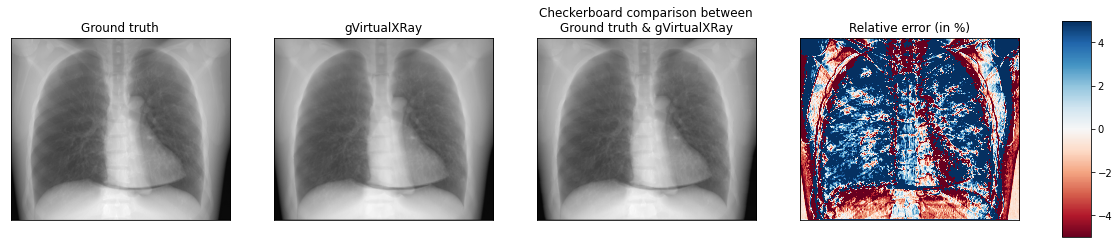

In [31]:
fullCompareImages(DRR_AP, xray_AP, "Radiograph comparisons (A-P)","plots/lungman_full_comparison_radiographs_A_P", vmin=DRR_AP.min(), vmax=DRR_AP.max());

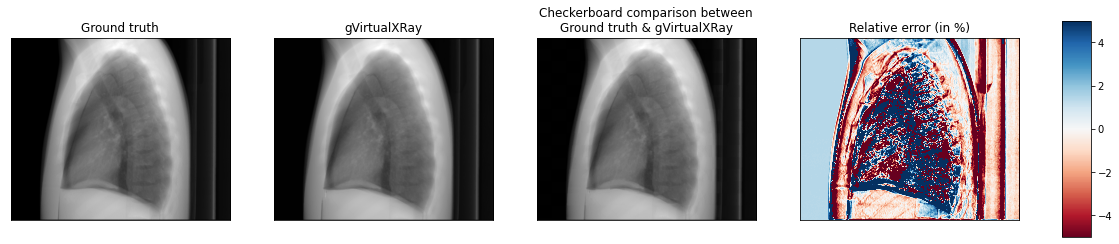

In [32]:
fullCompareImages(DRR_RL, xray_RL, "Radiograph comparisons (R-L)","plots/lungman_full_comparison_radiographs_R_L", vmin=DRR_RL.min(), vmax=DRR_RL.max());

## Profile plots

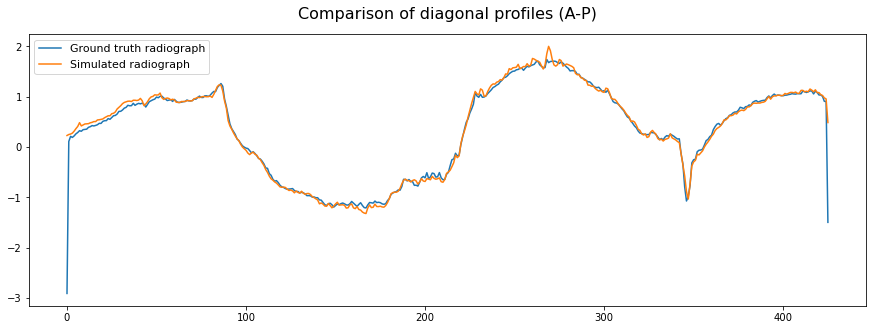

In [33]:
ref_diag = np.diag(xray_AP);
test_diag = np.diag(DRR_AP);

l = range(0, len(ref_diag));

plt.figure(figsize=(15,5))
plt.plot(l,ref_diag, label="Ground truth radiograph");

plt.plot(l,test_diag, label="Simulated radiograph");

plt.legend(loc=2,bbox_to_anchor=(0,1),prop={'size': 11})
plt.title("Comparison of diagonal profiles (A-P)",size=16,pad=15);

plt.savefig('plots/lungman-radiograph-profiles.pdf');
plt.savefig('plots/lungman-radiograph-profiles.png');

plt.show();

# Quantative comparisons

In [34]:
def formatMeasureResult(measure_result):
    s = "MAE:  {mae:.3f}\n\
ZNCC: {zncc:.3f}%\n\
RMSE: {rmse:.3f}\n\
MAPE: {mape:.3f}\n\
SSIM: {ssim:.3f}\n";
    return s.format(mae=measure_result[0], zncc=measure_result[1] * 100.0, rmse=measure_result[2], 
                    mape=measure_result[3], ssim=measure_result[4]);

In [35]:
measure_result = measure(DRR_RL, xray_RL);

s = formatMeasureResult(measure_result);
print(s);

print("Lungman - simulated projection & DRR of lungman phantom CT & " + "{0:0.2f}".format(measure_result[3]) +
      "    &    " +
      "{0:0.2f}".format(100 * measure_result[1]) + "\\%    &    " +
      "{0:0.2f}".format(measure_result[4]) + "    &    $" +
      str(DRR_RL.shape[1]) + " \\times " + str(DRR_RL.shape[0]) + "$    &    " +
      f"{number_of_triangles:,}" + "    &    " + "N/A" +
      "  & $" + str(runtimes_mean) + " \\pm " + str(runtimes_std) + "$ \\\\")

MAE:  0.029
ZNCC: 99.756%
RMSE: 0.070
MAPE: 0.317
SSIM: 0.932

Lungman - simulated projection & DRR of lungman phantom CT & 0.32    &    99.76\%    &    0.93    &    $512 \times 426$    &    19,277,756    &    N/A  & $52 \pm 27$ \\


In [36]:
#mae, zncc, rmse, mape, ssim = measure(DRR_AP, xray_AP);
measure_result = measure(DRR_AP, xray_AP);

print(formatMeasureResult(measure_result));

MAE:  0.059
ZNCC: 98.709%
RMSE: 0.161
MAPE: 0.409
SSIM: 0.867

